# Bolsas CNPq

https://github.com/abevieiramota/dataset-bolsas-cnpq

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [45]:
df = pd.read_csv("../../dataset-bolsas-cnpq/dataset.csv")

In [4]:
df.shape

(2140823, 18)

In [5]:
df.sample().T

,805384
ANO-PAGAMENTO,2009
CODIGO-DO-PROCESSO,301131/2005-8
QUANTIDADE-BOLSA-ANO,0.17
QUANTIDADE-MESES-PAGOS,2
SEXO,M
SIGLA-UF-INSTITUICAO,SC
VALOR-PAGO,1952
NOME-CURSO-ID,769
NOME-DA-AREA-DO-CONHECIMENTO-ID,71
NOME-DA-ESPECIALIDADE-ID,549


# Identificando grande area do conhecimento

In [46]:
df = pd.merge(df, pd.read_csv("../../dataset-bolsas-cnpq/TITULO-DO-PROCESSO.csv"))
df = pd.merge(df, pd.read_csv("../../dataset-bolsas-cnpq/NOME-GRANDE-AREA-DO-CONHECIMENTO.csv"))
df["TITULO-DO-PROCESSO"].fillna("SEM-TITULO", inplace=True)
df["NOME-GRANDE-AREA-DO-CONHECIMENTO"].fillna("SEM-NOME", inplace=True)

In [30]:
df["NOME-GRANDE-AREA-DO-CONHECIMENTO"].value_counts()

Engenharias e Ciência da Computação    435857
Ciências Exatas e da Terra             358323
Ciências Biológicas                    315486
Ciências Agrárias                      293807
Ciências Humanas                       246457
Ciências da Saúde                      218324
Ciências Sociais Aplicadas             145837
Lingüística, Letras e Artes             71310
Não se aplica                           27077
Outra                                   24623
Não informado                            3722
Name: NOME-GRANDE-AREA-DO-CONHECIMENTO, dtype: int64

In [50]:
por_gac = df.groupby("NOME-GRANDE-AREA-DO-CONHECIMENTO").apply(lambda g: g["TITULO-DO-PROCESSO"].str.cat(sep=" "))

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import nltk

In [75]:
tfidf = TfidfVectorizer(stop_words=nltk.corpus.stopwords.words("portuguese"), ngram_range=(1, 2)).fit(por_gac)

le = LabelEncoder().fit(df["NOME-GRANDE-AREA-DO-CONHECIMENTO"])

In [76]:
kn = KNeighborsClassifier().fit(tfidf.transform(df["TITULO-DO-PROCESSO"]), le.transform(df["NOME-GRANDE-AREA-DO-CONHECIMENTO"]))

In [77]:
le.inverse_transform(kn.predict(tfidf.transform(["clarice lispector"])))

array(['Lingüística, Letras e Artes'], dtype=object)

In [78]:
le.inverse_transform(kn.predict(tfidf.transform(["os bois e as vacas são amigos"])))

array(['Ciências Agrárias'], dtype=object)

In [79]:
le.inverse_transform(kn.predict(tfidf.transform(["mineração de dados no combate à evasão de discentes"])))

array(['Ciências Exatas e da Terra'], dtype=object)

In [82]:
le.inverse_transform(kn.predict(tfidf.transform(["programação orientada a objetos"])))

array(['Engenharias e Ciência da Computação'], dtype=object)

In [84]:
le.inverse_transform(kn.predict(tfidf.transform(["a sociedade o burguês o estado e o capitalismo"])))

array(['Ciências Sociais Aplicadas'], dtype=object)

# Quantidade por estado e ano

In [81]:
# contando a quantidade de registros por ano
qpea = df.groupby(["SIGLA-UF-INSTITUICAO", "ANO-PAGAMENTO"]).size().unstack()
qpea.head(3)

ANO-PAGAMENTO,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
SIGLA-UF-INSTITUICAO,,,,,,,,,,,,,,,,,
AC,108.0,75.0,83.0,110.0,105.0,132.0,135.0,212.0,247.0,282.0,384.0,438.0,594.0,484.0,593.0,490.0,273.0
AL,511.0,494.0,424.0,459.0,526.0,599.0,635.0,823.0,1010.0,1208.0,1313.0,1380.0,1454.0,1718.0,1644.0,1378.0,662.0
AM,937.0,1028.0,1132.0,1235.0,1248.0,1592.0,1590.0,1750.0,1956.0,2089.0,2386.0,2283.0,2269.0,2147.0,2269.0,1786.0,924.0


In [120]:
# contando a quantidade de processos que não existiam no ano anterior
def calcula_qtd_novos_processos_por_ano(g):
    
    ggs = [group for _, group in g.groupby(["ANO-PAGAMENTO"])]
    re = pd.DataFrame(np.nan, columns=["NOVOS", "ANTIGOS", "TOTAL"], index=g["ANO-PAGAMENTO"].unique())
   
    re.iloc[0, 0] = ggs[0].shape[0]
    re.iloc[0, 1] = np.nan
    re.iloc[0, 2] = ggs[0].shape[0]
    
    for i in range(0, len(ggs) - 1):
        
        codigos0 = set(ggs[i]["CODIGO-DO-PROCESSO"].unique())
        codigos1 = set(ggs[i+1]["CODIGO-DO-PROCESSO"].unique())
        
        re.iloc[i+1, 0] = len(codigos1.difference(codigos0))
        re.iloc[i+1, 1] = len(codigos1.intersection(codigos0))
        re.iloc[i+1, 2] = len(codigos1)
    
    return re.T

qpea = df.groupby(["SIGLA-UF-INSTITUICAO"]).apply(calcula_qtd_novos_processos_por_ano)
qpea.unstack().head(8)

2001                    2002                    2003  \
                       NOVOS ANTIGOS   TOTAL   NOVOS ANTIGOS   TOTAL   NOVOS   
SIGLA-UF-INSTITUICAO                                                           
AC                     108.0     NaN   108.0    28.0    46.0    74.0    34.0   
AL                     511.0     NaN   511.0   159.0   301.0   460.0   168.0   
AM                     937.0     NaN   937.0   432.0   524.0   956.0   531.0   
AP                      24.0     NaN    24.0     7.0    14.0    21.0    15.0   
BA                    1770.0     NaN  1770.0   628.0   990.0  1618.0   819.0   
CE                    2454.0     NaN  2454.0   601.0  1351.0  1952.0   894.0   
DF                    5214.0     NaN  5214.0  2089.0  3382.0  5471.0  1890.0   
ES                     517.0     NaN   517.0   165.0   297.0   462.0   207.0   

                                        2004   ...       2014    2015          \
                     ANTIGOS   TOTAL   NOVOS   ...      TOTAL   NOVOS ANTIGOS   
SIGLA-UF-INSTITUICAO                           ...                              
AC                      46.0    80.0    44.0   ...      484.0   338.0   255.0   
AL                     249.0   417.0   195.0   ...     1717.0   917.0   727.0   
AM                     548.0  1079.0   438.0   ...     2139.0  1194.0  1072.0   
AP                       8.0    23.0     8.0   ...      528.0   218.0   203.0   
BA                    1003.0  1822.0   890.0   ...     5309.0  2860.0  2362.0   
CE                    1094.0  1988.0   948.0   ...     6288.0  3279.0  2877.0   
DF                    3623.0  5513.0  1989.0   ...    10137.0  7035.0  4584.0   
ES                     264.0   471.0   243.0   ...     1445.0   827.0   767.0   

                                 2016                   2017                  
                        TOTAL   NOVOS ANTIGOS   TOTAL  NOVOS ANTIGOS   TOTAL  
SIGLA-UF-INSTITUICAO                                                          
AC                      593.0   248.0   237.0   485.0   43.0   230.0   273.0  
AL                     1644.0   646.0   614.0  1260.0  137.0   504.0   641.0  
AM                     2266.0   738.0  1044.0  1782.0  150.0   774.0   924.0  
AP                      421.0   125.0   185.0   310.0   19.0    90.0   109.0  
BA                     5222.0  2010.0  2562.0  4572.0  384.0  1944.0  2328.0  
CE                     6156.0  2483.0  2791.0  5274.0  407.0  2083.0  2490.0  
DF                    11619.0  3433.0  5209.0  8642.0  542.0  3682.0  4224.0  
ES                     1594.0   669.0   763.0  1432.0  119.0   609.0   728.0  

[8 rows x 51 columns]

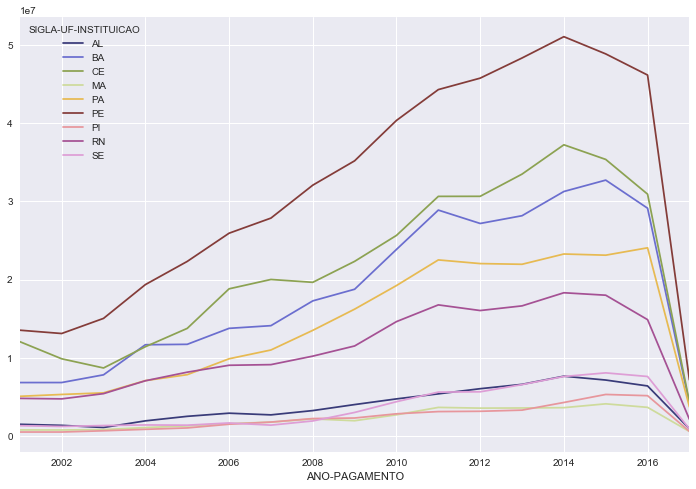

In [121]:
nordeste = ['CE', 'PE', 'RN', 'BA', 'MA', 'AL', 'PI', 'PA', 'SE']

df.groupby(['ANO-PAGAMENTO', 'SIGLA-UF-INSTITUICAO'])['VALOR-PAGO'].sum()\
.loc[(slice(None), nordeste)]\
.unstack().plot(figsize=(12, 8), cmap=plt.cm.Vega20b)

In [122]:
modalidade = pd.read_csv("../dataset-bolsas-cnpq/MODALIDADE-DO-PROCESSO.csv")

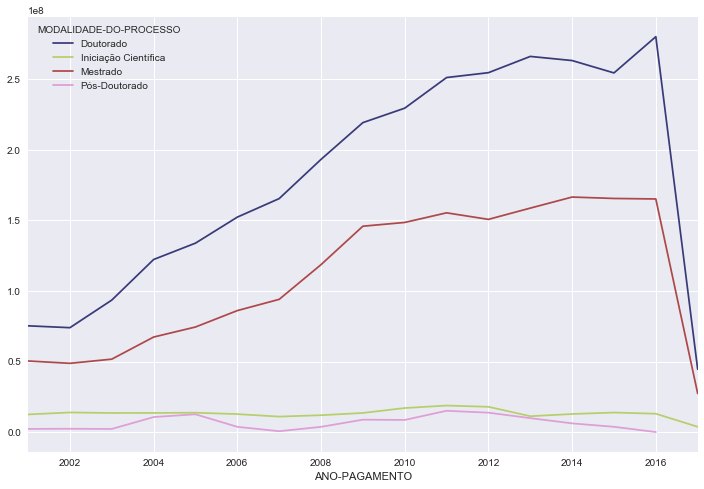

In [125]:
pd.merge(df, modalidade).groupby(['ANO-PAGAMENTO', 'MODALIDADE-DO-PROCESSO'])['VALOR-PAGO'].sum()\
.loc[(slice(None), ['Mestrado', 'Doutorado', 'Pós-Doutorado', 'Iniciação Científica'])]\
.unstack().plot(figsize=(12, 8), cmap=plt.cm.Vega20b)